In [2]:
%matplotlib inline

import pandas as pd
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
from scipy.stats import kendalltau
import numpy as np

import scanpy as sc

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

In [77]:
adata = sc.read('/home/ngr4/project/scnd/data/processed/mouse_200614.h5ad')

AttributeError: module 'scanpy' has no attribute 'read'

In [76]:
def snrnaVmfish(dge_file_magic='/home/ngr4/project/scnd/results/dge*{}wk*_imp*down*csv',
                timepoints=[5, 18, 30],
                fish_file='/home/ngr4/project/scnd/results/210716_merfish_de.csv', 
                ctype = 'Purkinje cell',
                out_file=None,
                redo_dge=False):
    '''Compare snRNA-seq to MERFISH DGE analysis via correlation & scatterplots
    
    TODO (enhancement):
      - redo l2fc and dge calc for limited set of genes and functionalize those, not throwing out genes
      
    '''

    fish = pd.read_csv(fish_file)
    results = pd.DataFrame()
    for t in timepoints:
        files = glob.glob(dge_file_magic.format(t))
        for i, f in enumerate(files):
            print('\n  processing file #{}: {}'.format(i, f))
        d = pd.read_csv(files[0])
        d = d.loc[d['Cell type']=='Purkinje cell', :]
        idx = np.where(fish.columns=='{}wk'.format(t))[0][0]
        dt = fish.iloc[1:, [0, idx, idx+1]]
        dt.columns = ['Gene', 'mfish_l2fc', 'mfish_padj']
        corr_df = d.merge(dt, left_on='Gene', right_on='Gene')
        rho_padj, p_rho_padj = pearsonr(corr_df['pval_corrected'], corr_df['mfish_padj'].astype(float))
        tau_padj, p_tau_padj = kendalltau(corr_df['pval_corrected'], corr_df['mfish_padj'].astype(float))
        rho_l2fc, p_rho_l2fc = pearsonr(corr_df['log2FC'], corr_df['mfish_l2fc'].astype(float))
        tau_l2fc, p_tau_l2fc = kendalltau(corr_df['log2FC'], corr_df['mfish_l2fc'].astype(float))

        print('    rho_padj: {:.4f} ({:.4f})\ttau_padj:  {:.4f} ({:.4f})\trho_l2fc: {:.4f} ({:.4f})\ttau_l2fc: {:.4f} ({:.4f})'.format(
            rho_padj, p_rho_padj, tau_padj, p_tau_padj, rho_l2fc, p_rho_l2fc, tau_l2fc, p_tau_l2fc))

        results  = results.append(pd.DataFrame({'Gene':corr_df['Gene'],
                                               'timepoint':['{}wk'.format(t)]*corr_df.shape[0],
                                               'padj':corr_df['pval_corrected'],
                                               'l2fc':corr_df['log2FC'],
                                               'mfish_padj':corr_df['mfish_padj'].astype(float),
                                               'mfish_l2fc':corr_df['mfish_l2fc'].astype(float)}), ignore_index=True)

    # plot
    fig, ax = plt.subplots(1, 2, figsize=(9,3))
    results['-log10 P adj'] = -1*np.log10(results['padj'])
    results['-log10 P adj (MERFISH)'] = -1*np.log10(results['mfish_padj'])
    sns.scatterplot(x='-log10 P adj', y='-log10 P adj (MERFISH)', data=results, 
                    hue='timepoint', linewidth=0, ax=ax[0])
    sns.scatterplot(x='l2fc', y='mfish_l2fc', data=results, 
                    hue='timepoint', linewidth=0, ax=ax[1])
    
    if out_file is not None:
        results.to_csv(out_file)
    


  processing file #0: /home/ngr4/project/scnd/results/dge_5wk_mouse_MT_imp_WTdown.csv
    rho_padj: -0.1258 (0.4647)	tau_padj:  -0.0843 (0.4702)	rho_l2fc: -0.0974 (0.5719)	tau_l2fc: -0.1016 (0.3834)

  processing file #0: /home/ngr4/project/scnd/results/dge_18wk_mouse_MT_imp_WTdown.csv
    rho_padj: 0.1015 (0.4246)	tau_padj:  0.0685 (0.4240)	rho_l2fc: -0.0539 (0.6725)	tau_l2fc: 0.0446 (0.6021)

  processing file #0: /home/ngr4/project/scnd/results/dge_30wk_mouse_MT_imp_WTdown.csv
    rho_padj: -0.5924 (0.0256)	tau_padj:  -0.4945 (0.0138)	rho_l2fc: -0.1054 (0.7198)	tau_l2fc: -0.1209 (0.5906)

  processing file #0: /home/ngr4/project/scnd/results/dge_5wk_mouse_MT_imp_WTup.csv
    rho_padj: 0.0042 (0.9813)	tau_padj:  -0.1430 (0.2355)	rho_l2fc: 0.3185 (0.0664)	tau_l2fc: 0.1408 (0.2415)

  processing file #0: /home/ngr4/project/scnd/results/dge_18wk_mouse_MT_imp_WTup.csv
    rho_padj: 0.2457 (0.0654)	tau_padj:  0.2767 (0.0024)	rho_l2fc: -0.0086 (0.9496)	tau_l2fc: -0.0150 (0.8688)

  proces

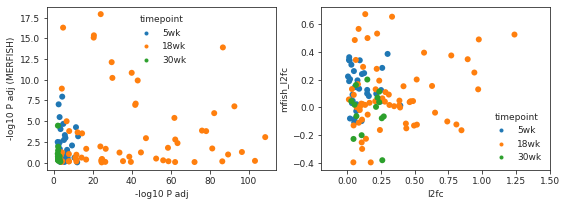

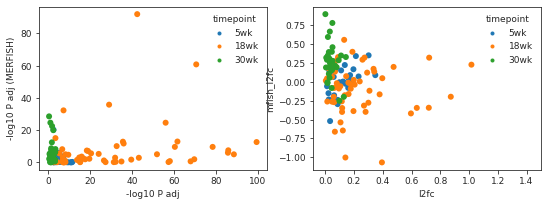

In [74]:
snrnaVmfish(dge_file_magic='/home/ngr4/project/scnd/results/dge*{}wk*_imp*down*csv',
            out_file='/home/ngr4/project/scnd/results/dge_snrnaVmfish_imp_WTdown.csv')
snrnaVmfish(dge_file_magic='/home/ngr4/project/scnd/results/dge*{}wk*_imp*up*csv',
            out_file='/home/ngr4/project/scnd/results/dge_snrnaVmfish_imp_WTup.csv')

In [43]:
glob.glob('/home/ngr4/project/scnd/results/dge*{}wk*_imp*down*csv'.format(t))

['/home/ngr4/project/scnd/results/dge_18wk_mouse_MT_imp_WTdown.csv']

In [38]:
rho, p_rho = pearsonr()
tau, p_tau = kendalltau()

Gene                       Zzz3
EMD                   -0.011328
Cell type         Purkinje cell
pval                   0.001319
pval_corrected         0.009965
log2FC                      inf
dtype: object

In [39]:
dt.shape

(140, 3)